# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import torch
from ddpg_agent import Agent, load_and_run

cuda:0


Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded. For example, the following are the default folder and file names. However, if you copied both version 1 (single agent) and version 2 (20 agents) folders, they may have different names if you changed them.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='./Reacher_Windows_x86_64_v2/Reacher.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])



Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Define the Learning Process using Deep Deterministic Policy Gradients

In [5]:

def ddpg(
    agent,
    checkpoint_name,
    n_episodes=2000,
    max_t=1500,
    gamma_initial = 0.9,
    gamma_final = 0.99,
    gamma_rate = 0.002,
    tau_initial = 0.01,
    tau_final = 0.001,
    tau_rate = 0.001,
    noise_factor = 1.0
):
    """
    Reinforcement learning with Deep Deterministic Policy Gradients
    agent (Agent): The learning agent
    checkpoint_name (string): A prefix string for naming all of the checkpoints of the actor and critic neural
        networks that are saved.
    n_episodes (int): Maximum number of training episodes
    max_t (int): Maximum number of timesteps per episode
    gamma_initial (float): Initial gamma discount factor (0 to 1). Higher values favor long term over current rewards.
    gamma_final (float): Final gamma discount factor (0 to 1).
    gammma_rate (float): A rate (0 to 1) for increasing gamma.
    tau_initial (float): Initial value for tau, the weighting factor for soft updating the neural networks.
    tau_final (float): Final value of tau.
    tau_rate (float): Rate (0 to 1) for increasing tau each episode.
    noise_factor (float<=1): The value for scaling the noise every episode to gradually decrease it.
    """
    
    gamma = gamma_initial
    gamma_scale = 1.0 - gamma_rate
    
    tau = tau_initial
    tau_scale = 1.0 - tau_rate
    
    noise_scale = 1.0
    success = False #Flag for indicating successfully achieving 100-episode-average score >30.
    first30 = False #Flag for indicating achieving an agent-aaverage score >30.
    maxAvgMax = 0.0
    bestAgAvg = 0.0
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        
        # Reset environment
        env_info = env.reset(train_mode=True)[brain_name]
        
        # Get next state
        state = env_info.vector_observations
        
        # state = env.reset()
        agent.reset()

        score = np.zeros(agent.num_agents)
        
        for t in range(max_t):
            
            # Get action
            action = agent.act(state, noise_scale)
            #print(action)

            # Send action to environment
            env_info = env.step(action)[brain_name]
            
            # Get next state
            next_state = env_info.vector_observations
            
            # Get reward
            reward = env_info.rewards
            
            # Check if episode is finished
            done = env_info.local_done
            
            agent.step(state, action, reward, next_state, done, gamma, tau)
            #score += reward
            score += np.array(env_info.rewards)                         # update the score (for each agent)
            state = next_state
            
            # Exit if episode is finished
            if np.any(done):
                break
                
        agent_avg = np.mean(score)
        agent_max = np.max(score)
        agent_min = np.min(score)
        scores_deque.append(agent_avg)
        scores.append(agent_avg)
        avg_score = np.mean(scores_deque)
        print('Ep {}\tEpAvg: {:.2f}\tAgAvg: {:.2f}\tmin: {:.2f}\tmax: {:.2f}\tg: {:.4f}\tns: {:.4f}\ttau: {:.4f}'.format(
            i_episode, avg_score, agent_avg, agent_min, agent_max, gamma, noise_scale, tau))
        if not first30 and agent_avg > 30:
            first30 = True
            bestAgAvg = agent_avg
            torch.save(agent.actor_local.state_dict(), checkpoint_name + '_actor_first.pth')
            torch.save(agent.critic_local.state_dict(), checkpoint_name + '_critic_first.pth')
            print("Agent-average score >30 after {:d} episodes.".format(i_episode))
        if i_episode >=100 and not success and avg_score > 30:
            success = True
            maxAvgMax = avg_score
            torch.save(agent.actor_local.state_dict(), checkpoint_name + '_actor.pth')
            torch.save(agent.critic_local.state_dict(), checkpoint_name + '_critic.pth')
            print("100-episode-average score >30 after {:d} episodes.".format(i_episode))
        if success and avg_score > maxAvgMax:
            maxAvgMax = avg_score
            torch.save(agent.actor_local.state_dict(), checkpoint_name + '_actor_best_episode_average.pth')
            torch.save(agent.critic_local.state_dict(), checkpoint_name + '_critic_best_episode_average.pth')
            print("New best 100-episode-average score at episode {:d}.".format(i_episode))
        if first30 and agent_avg > bestAgAvg:
            bestAgAvg = agent_avg
            torch.save(agent.actor_local.state_dict(), checkpoint_name + '_actor_best_agent_average.pth')
            torch.save(agent.critic_local.state_dict(), checkpoint_name + '_critic_best_agent_average.pth')
            print("New best agent-average score at episode {:d}.".format(i_episode))
                
        # Increase gamma discount factor. Limit to gamma_final.
        gamma = gamma_final - gamma_scale * (gamma_final - gamma)
        
        tau = tau_final - tau_scale * (tau_final - tau)
        
        noise_scale *= noise_factor

    torch.save(agent.actor_local.state_dict(), checkpoint_name + '_actor_final.pth')
    torch.save(agent.critic_local.state_dict(), checkpoint_name + '_critic_final.pth')
    return scores


## 4. Declare the Learning Agent

Agent has the following parameters:

    state_size: Number of parameters defining the environmen state
    action_size: Number of pameters definine the actions
    num_agents: Number of learning agents
    random_seed: Random seed number
    batch_size: Batch size for neural network training
    lr_actor: Learning rate for the actor neural network
    lr_critic: Learning rate for the critic neural network
    noise_theta (float): theta for Ornstein-Uhlenbeck noise process
    noise_sigma (float): sigma for Ornstein-Uhlenbeck noise process
    actor_fc1 (int): Number of hidden units in the first fully connected layer of the actor network
    actor_fc2: Units in second layer
    actor_fc3: Units in third fully connected layer. This parameter does nothing for the "RELU" network
    critic_fc1: Number of hidden units in the first fully connected layer of the critic network
    critic_fc2: Units in second layer
    critic_fc3: Units in third layer. This parameter does nothing for the "RELU" network
    update_every: The number of time steps between each updating of the neural networks 
    num_updates: The number of times to update the networks at every update_every interval
    buffer_size: Buffer size for experience replay. Default 2e6.
    network (string): The name of the neural networks that are used for learning.
        There are 	only 2 choices, one with only 2 fully connected layers and RELU activations and one
        with 3 fully connected layers with SELU activations.
        Their names are "RELU" and "SELU," respectively. Default is "RELU."


In [6]:

agent = Agent(
    state_size = state_size,
    action_size = action_size,
    num_agents = num_agents,
    random_seed = 0,
    batch_size = 1024, 
    lr_actor = 0.001,
    lr_critic = 0.001,
    noise_theta = 0.45,
    noise_sigma = 0.6,
    actor_fc1 = 128,
    actor_fc2 = 64,
    critic_fc1 = 128,
    critic_fc2 = 64,
    update_every = 20,
    num_updates = 5,
    buffer_size = int(2e6),
    network = 'RELU'
)


## 5. Train the Agent

Perform the training and collect the scores. The following are printed for every episode:

    Ep: The episode number
    EpAvg: The score averaged over all of the agents and over the current and previous 99 episodes.
    AgAvg: The score averaged over all the agents.
    min and max: The lowest and highest score achieved by the agents in the current episode. For a single agent,
        AgAvg, min, and max should be the same
    g: The gamma discount factor for the current episode.
    ns: The noise scaling factor for the current episode.
    tau: The weight factor used for soft updating for the current episode.
    
    Messages will appear to notidy the user when various achievements occur:
        1. First time achieving AgAvg >30
        2. First time achieving EpAvg >30
        3. Each time a new best AgAvg is achieved
        4. Each time a new EpAvg is achieved
        
        A checkpoint is saved at each of these notifications. The checkpoint is overwritten for 3 and 4.

In [7]:
prefix_name = 'v2_RELU'

scores = ddpg(
    agent,
    checkpoint_name = prefix_name,
    n_episodes = 150,
    max_t = 10000,
    gamma_initial = 0.95,
    gamma_final = 0.99,
    gamma_rate = 0.01,
    tau_initial = 0.01,
    tau_final = 0.001,
    tau_rate = 0.1,
    noise_factor = 0.995
)


Ep 1	EpAvg: 0.42	AgAvg: 0.42	min: 0.00	max: 0.87	g: 0.9500	ns: 1.0000	tau: 0.0100
Ep 2	EpAvg: 0.54	AgAvg: 0.67	min: 0.00	max: 1.49	g: 0.9504	ns: 0.9950	tau: 0.0091
Ep 3	EpAvg: 0.57	AgAvg: 0.63	min: 0.00	max: 1.54	g: 0.9508	ns: 0.9900	tau: 0.0083
Ep 4	EpAvg: 0.60	AgAvg: 0.69	min: 0.06	max: 1.79	g: 0.9512	ns: 0.9851	tau: 0.0076
Ep 5	EpAvg: 0.65	AgAvg: 0.86	min: 0.15	max: 1.87	g: 0.9516	ns: 0.9801	tau: 0.0069
Ep 6	EpAvg: 0.75	AgAvg: 1.25	min: 0.44	max: 2.51	g: 0.9520	ns: 0.9752	tau: 0.0063
Ep 7	EpAvg: 0.87	AgAvg: 1.57	min: 0.37	max: 4.42	g: 0.9523	ns: 0.9704	tau: 0.0058
Ep 8	EpAvg: 0.94	AgAvg: 1.42	min: 0.34	max: 3.18	g: 0.9527	ns: 0.9655	tau: 0.0053
Ep 9	EpAvg: 1.03	AgAvg: 1.80	min: 0.65	max: 3.14	g: 0.9531	ns: 0.9607	tau: 0.0049
Ep 10	EpAvg: 1.18	AgAvg: 2.47	min: 0.49	max: 5.79	g: 0.9535	ns: 0.9559	tau: 0.0045
Ep 11	EpAvg: 1.36	AgAvg: 3.14	min: 0.70	max: 6.40	g: 0.9538	ns: 0.9511	tau: 0.0041
Ep 12	EpAvg: 1.49	AgAvg: 3.01	min: 0.69	max: 5.94	g: 0.9542	ns: 0.9464	tau: 0.0038
Ep 13	EpAvg: 

Ep 92	EpAvg: 27.20	AgAvg: 34.51	min: 32.06	max: 38.98	g: 0.9740	ns: 0.6337	tau: 0.0010
Ep 93	EpAvg: 27.28	AgAvg: 34.27	min: 28.61	max: 38.00	g: 0.9741	ns: 0.6306	tau: 0.0010
Ep 94	EpAvg: 27.35	AgAvg: 34.15	min: 28.57	max: 37.08	g: 0.9743	ns: 0.6274	tau: 0.0010
Ep 95	EpAvg: 27.43	AgAvg: 35.08	min: 30.38	max: 37.38	g: 0.9744	ns: 0.6243	tau: 0.0010
Ep 96	EpAvg: 27.50	AgAvg: 34.04	min: 28.88	max: 37.33	g: 0.9746	ns: 0.6211	tau: 0.0010
Ep 97	EpAvg: 27.57	AgAvg: 34.39	min: 32.30	max: 36.22	g: 0.9748	ns: 0.6180	tau: 0.0010
Ep 98	EpAvg: 27.65	AgAvg: 34.99	min: 31.93	max: 36.92	g: 0.9749	ns: 0.6149	tau: 0.0010
Ep 99	EpAvg: 27.71	AgAvg: 34.20	min: 30.16	max: 37.04	g: 0.9751	ns: 0.6119	tau: 0.0010
Ep 100	EpAvg: 27.78	AgAvg: 34.94	min: 32.99	max: 37.88	g: 0.9752	ns: 0.6088	tau: 0.0010
Ep 101	EpAvg: 28.13	AgAvg: 34.85	min: 30.51	max: 37.12	g: 0.9754	ns: 0.6058	tau: 0.0010
Ep 102	EpAvg: 28.48	AgAvg: 35.35	min: 31.92	max: 37.12	g: 0.9755	ns: 0.6027	tau: 0.0010
Ep 103	EpAvg: 28.82	AgAvg: 35.18	min: 33

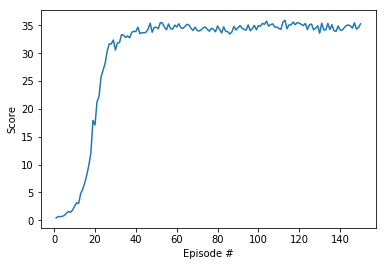

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## 6. Run the Trained Agent


In [5]:
agent = Agent(
    state_size = state_size,
    action_size = action_size,
    num_agents = num_agents,
    network = 'RELU'
)

load_and_run(
    agent,
    env,
    prefix_name + "_actor_best_agent_average.pth",
    prefix_name + "_critic_best_agent_average.pth",
    100)

Ep 1	Score: 38.29
Ep 2	Score: 38.44
Ep 3	Score: 38.40
Ep 4	Score: 38.16
Ep 5	Score: 38.41
Ep 6	Score: 38.50
Ep 7	Score: 38.66
Ep 8	Score: 38.67
Ep 9	Score: 38.41
Ep 10	Score: 38.31
Ep 11	Score: 38.11
Ep 12	Score: 38.39
Ep 13	Score: 38.51
Ep 14	Score: 38.34
Ep 15	Score: 38.66
Ep 16	Score: 38.07
Ep 17	Score: 38.66
Ep 18	Score: 38.12
Ep 19	Score: 38.49
Ep 20	Score: 38.13
Ep 21	Score: 38.77
Ep 22	Score: 38.58
Ep 23	Score: 38.60
Ep 24	Score: 38.48
Ep 25	Score: 38.13
Ep 26	Score: 38.45
Ep 27	Score: 38.46
Ep 28	Score: 38.55
Ep 29	Score: 38.64
Ep 30	Score: 38.10
Ep 31	Score: 38.32
Ep 32	Score: 38.61
Ep 33	Score: 38.40
Ep 34	Score: 38.63
Ep 35	Score: 37.93
Ep 36	Score: 38.64
Ep 37	Score: 38.47
Ep 38	Score: 38.35
Ep 39	Score: 38.45
Ep 40	Score: 38.34
Ep 41	Score: 37.83
Ep 42	Score: 38.16
Ep 43	Score: 38.56
Ep 44	Score: 38.61
Ep 45	Score: 38.32
Ep 46	Score: 38.60
Ep 47	Score: 38.21
Ep 48	Score: 38.42
Ep 49	Score: 38.31
Ep 50	Score: 38.19
Ep 51	Score: 38.71
Ep 52	Score: 38.28
Ep 53	Score: 38.59
Ep

When finished, you can close the environment.

In [10]:
env.close()